## Import and Define

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
from scipy import signal
from numpy.fft import fft, ifft
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn import metrics  
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
#from tpot import TPOTClassifier
import biobss

C:\Users\ASUS\miniconda3\envs\python310env\lib\site-packages\plotly_resampler\aggregation\aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")
C:\Users\ASUS\miniconda3\envs\python310env\lib\site-packages\antropy\fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit('float64(float64[:], int32)')


## Data extraction

In [2]:
patients = []
for i in range(2,12):
    patients.append(pkl.load(open(r'D:\\WESAD\\S{}\\S{}.pkl'.format(i,i),'r+b'), encoding='latin1'))
for i in range(13,18):
    patients.append(pkl.load(open(r'D:\\WESAD\\S{}\\S{}.pkl'.format(i,i),'r+b'), encoding='latin1'))

In [3]:
wTemp = []
cTemp = []
bvp = []
wEDA = []
cEDA = []
states = []
for i in patients:
    wTemp.append(i['signal']['wrist']['TEMP'][0:20892]) # 3656100/175 = 20892
    cTemp.append(i['signal']['chest']['Temp'][0:3656100]) # 3656100
    bvp.append(i['signal']['wrist']['BVP'][0:334272]) # 3656100*64/700 = 334272
    wEDA.append(i['signal']['wrist']['EDA'][0:20892]) # 3656100/175 = 20892
    cEDA.append(i['signal']['chest']['EDA'][0:3656100]) # 3656100
    states.append(i['label'][0:3656100]) # 3656100

array([[-59.37, -53.42, -44.4 , ...,  25.  ,  25.75,  26.51],
       [ 16.49,  15.8 ,  14.58, ...,  -0.52,   0.67,   1.65],
       [ -3.69,  -5.53,  -7.82, ...,  34.49,  34.14,  33.99],
       ...,
       [  1.35,   1.15,   1.13, ...,  -4.46,  -0.57,   2.97],
       [ -1.6 ,  -2.09,  -2.72, ..., -13.3 , -13.69, -14.67],
       [ -0.49,  -0.38,  -0.36, ...,   1.12,   0.41,  -0.43]])

In [4]:
# print(len(wTemp[1])*175,len(cTemp[1]),len(wEDA[1])*175,len(cEDA[1]),len(bvp[1])*700/64,len(states[1]))
# print(len(wTemp[1]),len(cTemp[1]),len(wEDA[1]),len(cEDA[1]),len(bvp[1]),len(states[1]))
# print(patients[0])

## Graphs

In [5]:
# fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15)) = plt.subplots(3, 5, figsize=(12,9))
# fig.suptitle('Patient states')
# for i in range(1,16):
#     exec(f'ax{i}.plot(cTemp[i-1])')
# plt.show()

## Fewest data points

In [6]:
min_len = 10000000
max3_len = 0
count3 = 0
min_patient = 0
coord3 = []
'''for i in range(len(states)):
    if len(states[i]) < min_len:
        min_len = len(states[i])
        min_patient = i
    count3 = 0
    for j in range(len(states[i])):
        if (states[i][j] == 3) and (max3_len < count3):
            max3_len = count3
            coord3 = [i+1,j]
        count3 += 1
''' #commented out for speed of execution

print(f'Patient {min_patient+1} has the fewest data points of {min_len}. The last 3 appears at coordinate {coord3}.')

Patient 1 has the fewest data points of 10000000. The last 3 appears at coordinate [].


## States Processing

In [7]:
states_norm = [[]*15 for n in range(15)]
for i in range(len(states)):
    for j in range(175,len(states[i]),700):
        for k in range(0,700,350):
            states_norm[i].append(states[i][j+k])
            #if ((j+k<1500) or (j+k>3654600)) and (i==0):
                #print(j,k,j+k)
#print(len(states[0])/350,len(states_norm[0]))

# match frequency with temperature
states_norm_temp = [[]*15 for n in range(15)]
for i in range(len(states_norm)):
    for j in range(10,10080,20):
        states_norm_temp[i].append(states_norm[i][j])
        #print(j)
#print(len(states[0])/350,len(states_norm[0]),len(states_norm_temp[0]))

In [8]:
states_clean_bin = [[]*15 for n in range(15)]
states_clean_tri = [[]*15 for n in range(15)]
for i in range(len(states_norm)):
    for j in states_norm[i]:
        if (j > 3) or (j == 0):
            j = 1 # 1 = not stressed
        states_clean_bin[i].append(j)
        states_clean_tri[i].append(j)
        if j == 3:
            j = 1
            states_clean_bin[i].pop()
            states_clean_bin[i].append(j)

# match frequency with temperature
states_clean_bin = [[]*15 for n in range(15)]
states_clean_tri = [[]*15 for n in range(15)]
for i in range(len(states_norm_temp)):
    for j in states_norm_temp[i]:
        if (j > 3) or (j == 0):
            j = 1 # 1 = not stressed
        states_clean_bin[i].append(j)
        states_clean_tri[i].append(j)
        if j == 3:
            j = 1
            states_clean_bin[i].pop()
            states_clean_bin[i].append(j)
#print(len(states_clean_bin[1]),len(states_clean_tri[1]))

In [9]:
# fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15)) = plt.subplots(3, 5, figsize=(12,9))
# fig.suptitle('Patient states')
# for i in range(1,16):
#     exec(f'ax{i}.plot(states_clean_tri[i-1])')
# plt.show()

## Temperature

### Fix artefact

In [10]:
'''for i in range(len(cTemp)):
    #print(f'old cTemp[{i}]: {len(cTemp[i])}\nold wTemp[{i}]: {len(wTemp[i])}')
    cTemp[i] = np.concatenate((cTemp[i][0:1771700],cTemp[i][1771875:len(cTemp[i])]))
    wTemp[i] = np.delete(wTemp[i],10124)
    print(f'new cTemp[{i}]: {len(cTemp[i])}\nnew wTemp[{i}]: {len(wTemp[i])}\n') # output
# If block is ran more than once, the second block of "Data extraction" has to be run again.''' # delete artefact from each set.

#print(cTemp[1][1771709])
#print(cTemp[1][1771793])
for i in range(1,93-9):
    cTemp[1][1771709+i] = (cTemp[1][1771709]+cTemp[1][1771793])/2
#for i in range(0,176):
#    print(cTemp[1][1771700+i])

### Match frequencies of wTemp and cTemp

In [11]:
cTemp_norm = [[]*15 for n in range(15)]
for i in range(len(cTemp)):
    for j in range(87,len(cTemp[i]),175):
        cTemp_norm[i].append(cTemp[i][j])
    #print(f'wTemp[{i}]: {len(wTemp[i])}\ncTemp[{i}]: {len(cTemp_norm[i])}\n')

### Filtering

In [12]:
#Flatten
wTemp_flat = np.asarray(wTemp)
cTemp_flat = np.asarray(cTemp_norm)
wTemp_flat = wTemp_flat.flatten()
cTemp_flat = cTemp_flat.flatten()

#print(np.shape(cTemp_flat),np.shape(wTemp))

In [13]:
window_size = 120
wTemp_ma = [[]*15 for n in range(15)]
cTemp_ma = [[]*15 for n in range(15)]
weights = np.ones(window_size)/window_size
    
for i in range(len(wTemp)):
    wTemp_ma[i] = np.convolve(wTemp_flat[20892*i:20892*(i+1)],weights,mode='same')
    cTemp_ma[i] = np.convolve(cTemp_flat[20892*i:20892*(i+1)],weights,mode='same')
    #print(f'wTemp[{i}]: {len(wTemp_ma[i])}\ncTemp[{i}]: {len(cTemp_norm[i])}\n')

In [14]:
'''fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle('Wrist Temperature')
ax1.plot(wTemp[1])
ax1.set_xlim(0,len(wTemp[1]))
ax1.set_title('Raw')
ax2.plot(wTemp_ma[1])
ax2.set_xlim(0,len(wTemp_ma[1]))
ax2.set_title('Moving Average')
ax3.plot(wTemp[1])
ax3.set_xlim(0,240) # 60 seconds
ax4.plot(wTemp_ma[1])
ax4.set_xlim(0,240) # 60 seconds
plt.show()'''

"fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,6))\nfig.suptitle('Wrist Temperature')\nax1.plot(wTemp[1])\nax1.set_xlim(0,len(wTemp[1]))\nax1.set_title('Raw')\nax2.plot(wTemp_ma[1])\nax2.set_xlim(0,len(wTemp_ma[1]))\nax2.set_title('Moving Average')\nax3.plot(wTemp[1])\nax3.set_xlim(0,240) # 60 seconds\nax4.plot(wTemp_ma[1])\nax4.set_xlim(0,240) # 60 seconds\nplt.show()"

### Feature extraction

In [15]:
#print(len(wTemp[1]),len(wTemp_ma[1]),'\nseconds',len(wTemp_ma[1])/4)
cTemp_Mean = [[]*15 for n in range(15)]
cTemp_Max = [[]*15 for n in range(15)]
cTemp_Min = [[]*15 for n in range(15)]
cTemp_Std = [[]*15 for n in range(15)]
wTemp_Mean = [[]*15 for n in range(15)]
wTemp_Max = [[]*15 for n in range(15)]
wTemp_Min = [[]*15 for n in range(15)]
wTemp_Std = [[]*15 for n in range(15)]
#40 = (1 value every 10 seconds)^-1 * 4 samples per second 
#(2 values per second )^-1 * 64 samples per second = 32 
#0.5 seconds per value * 64 samples per second = 32 
for i in range(len(cTemp_norm)):
    cTemp[i] = cTemp_norm[i][0:5040*4]
    wTemp[i] = wTemp[i][0:5040*4]
    count = 0
    for j in range(0,len(cTemp[i]),40): 
        cTemp_sum = 0
        wTemp_sum = 0
        cTemp_Max[i].append(np.max(cTemp[i][j:j+39]))
        cTemp_Min[i].append(np.min(cTemp[i][j:j+39]))
        cTemp_Std[i].append(np.std(cTemp[i][j:j+39]))
        wTemp_Max[i].append(np.max(wTemp[i][j:j+39]))
        wTemp_Min[i].append(np.min(wTemp[i][j:j+39]))
        wTemp_Std[i].append(np.std(wTemp[i][j:j+39]))
        #print(j, cTemp_Max[i][count], cTemp_Min[i][count], cTemp_Std[i][count])
        for k in range(0,40):
            cTemp_sum += cTemp[i][j+k]
            wTemp_sum += wTemp[i][j+k]
            #print(j+k)
        cTemp_Mean[i].append(cTemp_sum/40)
        wTemp_Mean[i].append(wTemp_sum/40)
        count += 1
#print(len(cTemp[1]),len(cTemp_Max[1]),len(wTemp[1]),len(wTemp_Max[1]))

In [16]:
# for i in ['cTemp_Max', 'cTemp_Min', 'cTemp_Std', 'cTemp_Mean', 'wTemp_Max', 'wTemp_Min', 'wTemp_Std', 'wTemp_Mean']:
#     exec(f'{i} = [[]*15 for n in range(15)]')
# for i in ['cTemp','wTemp']:
#     for j in range(15):
#         exec(f'{i}[j] = {i}_ma[j][5040*4]')
#         for k in range(0,5040*4,40):
#             exec(f'{i}_sum = 0')
#             # exec(f'{i}_Max[j].append(np.max({i}[j][k:k+39]))')
#             # exec(f'{i}_Min[j].append(np.min({i}[j][k:k+39]))')
#             # exec(f'{i}_Std[j].append(np.std({i}[j][k:k+39]))')
#             # for l in range(0,40):
#             #     exec(f'{i}_sum += {i}_[j][k+l]')
#                 #print(k+l)
#             exec(f'{i}_Mean[j].append({i}_sum/40)')
#     print({i}[0:2])

## PPG

### Filtering

In [17]:
#ButterWorth
bvp_bw = [[]*15 for n in range(15)]
sos = signal.butter(50,[0.5,5],'bandpass',fs=64,output = 'sos')
for i in range(len(bvp)):
    bvp_bw[i] = signal.sosfilt(sos,bvp[i].flatten())

In [18]:
#Detrend
bvp_dt = []
x = [i for i in range(0,len(bvp_bw[1]))]
x = np.reshape(x,(len(x),1))
model = LinearRegression()
for i in range(len(bvp)):
    model.fit(x,bvp_bw[i])
    trend = model.predict(x)
    detrend = [bvp_bw[i][j] - trend[j] for j in range(len(bvp_bw[i]))]
    bvp_dt.append(detrend)

In [19]:
#Flatten
bvp_flat = np.asarray(bvp_dt)
bvp_flat = bvp_flat.flatten()

In [20]:
#Moving Average
bvp_ma = [[]*15 for n in range(15)]
weights = np.ones(4)/4
for i in range(len(bvp)):
    bvp_ma[i] = np.convolve(bvp_flat[334272*i:334272*(i+1)],weights,mode='same')

### Feature extraction

In [21]:
ppg_a_S_arr = [[]*15 for n in range(15)]
ppg_t_S_arr = [[]*15 for n in range(15)]
ppg_t_C_arr = [[]*15 for n in range(15)]
ppg_DW_arr = [[]*15 for n in range(15)]
ppg_SW_10_arr = [[]*15 for n in range(15)]
ppg_SW_25_arr = [[]*15 for n in range(15)]
ppg_SW_33_arr = [[]*15 for n in range(15)]
ppg_SW_50_arr = [[]*15 for n in range(15)]
ppg_SW_66_arr = [[]*15 for n in range(15)]
ppg_SW_75_arr = [[]*15 for n in range(15)]
ppg_DW_10_arr = [[]*15 for n in range(15)]
ppg_DW_25_arr = [[]*15 for n in range(15)]
ppg_DW_33_arr = [[]*15 for n in range(15)]
ppg_DW_50_arr = [[]*15 for n in range(15)]
ppg_DW_66_arr = [[]*15 for n in range(15)]
ppg_DW_75_arr = [[]*15 for n in range(15)]
ppg_DW_SW_10_arr = [[]*15 for n in range(15)]
ppg_DW_SW_25_arr = [[]*15 for n in range(15)]
ppg_DW_SW_33_arr = [[]*15 for n in range(15)]
ppg_DW_SW_50_arr = [[]*15 for n in range(15)]
ppg_DW_SW_66_arr = [[]*15 for n in range(15)]
ppg_DW_SW_75_arr = [[]*15 for n in range(15)]
ppg_PR_mean_arr = [[]*15 for n in range(15)]
ppg_zcr_arr = [[]*15 for n in range(15)]
ppg_snr_arr = [[]*15 for n in range(15)]

window_size = 640
for i in range(len(bvp)):
    bvp_ma[i] = bvp_ma[i][0:64*5040]
    bvp[i] = bvp[i][0:64*5040]
    for j in range(0,len(bvp_ma[0]),window_size):
        info=biobss.ppgtools.ppg_detectpeaks(sig=bvp_ma[i][j:j+window_size-1], sampling_rate=64, method='peakdet', delta=0.01, correct_peaks=True)
        locs_peaks=info['Peak_locs']
        peaks=[locs_peaks]
        locs_onsets=info['Trough_locs']
        onsets=bvp_ma[i][locs_onsets]
        signals={'Raw': bvp[i], 'Filtered': bvp_ma[i]}
        peaks={'Raw':{'Peaks': locs_peaks, 'Onsets': locs_onsets} , 'Filtered': {'Peaks': locs_peaks, 'Onsets':locs_onsets}}
        bvp_feats = biobss.ppgtools.ppg_features.ppg_time_features(bvp_ma[i][j:j+window_size-1], sampling_rate=64, input_types=['cycle','segment'], peaks_locs=locs_peaks, troughs_locs=locs_onsets)
        
        ppg_a_S_arr[i].append(bvp_feats.get('ppg_a_S'))
        ppg_t_S_arr[i].append(bvp_feats.get('ppg_t_S'))
        ppg_t_C_arr[i].append(bvp_feats.get('ppg_t_C'))
        ppg_DW_arr[i].append(bvp_feats.get('ppg_DW'))
        ppg_SW_10_arr[i].append(bvp_feats.get('ppg_SW_10'))
        ppg_SW_25_arr[i].append(bvp_feats.get('ppg_SW_25'))
        ppg_SW_33_arr[i].append(bvp_feats.get('ppg_SW_33'))
        ppg_SW_50_arr[i].append(bvp_feats.get('ppg_SW_50'))
        ppg_SW_66_arr[i].append(bvp_feats.get('ppg_SW_66'))
        ppg_SW_75_arr[i].append(bvp_feats.get('ppg_SW_75'))
        ppg_DW_10_arr[i].append(bvp_feats.get('ppg_DW_10'))
        ppg_DW_25_arr[i].append(bvp_feats.get('ppg_DW_25'))
        ppg_DW_33_arr[i].append(bvp_feats.get('ppg_DW_33'))
        ppg_DW_50_arr[i].append(bvp_feats.get('ppg_DW_50'))
        ppg_DW_66_arr[i].append(bvp_feats.get('ppg_DW_66'))
        ppg_DW_75_arr[i].append(bvp_feats.get('ppg_DW_75'))
        ppg_DW_SW_10_arr[i].append(bvp_feats.get('ppg_DW_SW_10'))
        ppg_DW_SW_25_arr[i].append(bvp_feats.get('ppg_DW_SW_25'))
        ppg_DW_SW_33_arr[i].append(bvp_feats.get('ppg_DW_SW_33'))
        ppg_DW_SW_50_arr[i].append(bvp_feats.get('ppg_DW_SW_50'))
        ppg_DW_SW_66_arr[i].append(bvp_feats.get('ppg_DW_SW_66'))
        ppg_DW_SW_75_arr[i].append(bvp_feats.get('ppg_DW_SW_75'))
        ppg_PR_mean_arr[i].append(bvp_feats.get('ppg_PR_mean'))
        ppg_zcr_arr[i].append(bvp_feats.get('ppg_zcr'))
        ppg_snr_arr[i].append(bvp_feats.get('ppg_snr'))
        
print(len(ppg_a_S_arr[0]))

504


In [22]:
bvp_feats.keys()

dict_keys(['ppg_a_S', 'ppg_t_S', 'ppg_t_C', 'ppg_DW', 'ppg_SW_10', 'ppg_SW_25', 'ppg_SW_33', 'ppg_SW_50', 'ppg_SW_66', 'ppg_SW_75', 'ppg_DW_10', 'ppg_DW_25', 'ppg_DW_33', 'ppg_DW_50', 'ppg_DW_66', 'ppg_DW_75', 'ppg_DW_SW_10', 'ppg_DW_SW_25', 'ppg_DW_SW_33', 'ppg_DW_SW_50', 'ppg_DW_SW_66', 'ppg_DW_SW_75', 'ppg_PR_mean', 'ppg_zcr', 'ppg_snr'])

## EDA

### Fix artefact

In [23]:
for i in range(1,93-9):
    cEDA[1][1771709+i] = (cEDA[1][1771709]+cEDA[1][1771793])/2
for i in range(1,2100):
     cEDA[6][2264200+i] = (cEDA[6][2266300]-cEDA[6][2264200])*i/2100+cEDA[6][2264200]

### Match frequencies of wEDA and cEDA

In [24]:
cEDA_norm = [[]*15 for n in range(15)]
for i in range(len(cEDA)):
    for j in range(87,len(cEDA[i]),175):
        cEDA_norm[i].append(cEDA[i][j])
    #print(f'wEDA[{i}]: {len(wEDA[i])}\ncEDA[{i}]: {len(cEDA_norm[i])}\n')

### Filtering

In [25]:
#Flatten
cEDA_norm = np.asarray(cEDA_norm)
#ButterWorth
cEDA_bw = [[]*15 for n in range(15)]
wEDA_bw = [[]*15 for n in range(15)]
sos = signal.butter(4,[0.05 ,5],'bandpass',fs=700,output = 'sos')
for i in range(len(cEDA)):
    cEDA_bw[i] = signal.sosfilt(sos,cEDA_norm[i].flatten())
    wEDA_bw[i] = signal.sosfilt(sos,wEDA[i].flatten())

In [26]:
#Flatten
# bvp_flat = np.asarray(bvp_dt)
# bvp_flat = bvp_flat.flatten()

In [27]:
# #Moving Average
# bvp_ma = [[]*15 for n in range(15)]
# weights = np.ones(4)/4
# for i in range(len(bvp)):
#     bvp_ma[i] = np.convolve(bvp_flat[334272*i:334272*(i+1)],weights,mode='same')

### Feature Extraction

In [28]:
scr_mean_c = [[]*15 for n in range(15)]
scr_std_c = [[]*15 for n in range(15)]
scr_max_c = [[]*15 for n in range(15)]
scr_min_c = [[]*15 for n in range(15)]
scr_range_c = [[]*15 for n in range(15)]
scr_kurtosis_c = [[]*15 for n in range(15)]
scr_skew_c = [[]*15 for n in range(15)]
scr_momentum_c = [[]*15 for n in range(15)]
scr_activity_c = [[]*15 for n in range(15)]
scr_complexity_c = [[]*15 for n in range(15)]
scr_mobility_c = [[]*15 for n in range(15)]
scr_rms_c = [[]*15 for n in range(15)]
scr_acr_length_c = [[]*15 for n in range(15)]
scr_integral_c = [[]*15 for n in range(15)]
scr_average_power_c = [[]*15 for n in range(15)]
scr_f1sc_c = [[]*15 for n in range(15)]
scr_f2sc_c = [[]*15 for n in range(15)]
scr_f3sc_c = [[]*15 for n in range(15)]
scr_Energy_c = [[]*15 for n in range(15)]
scr_Entropy_c = [[]*15 for n in range(15)]
scr_max_freq_c = [[]*15 for n in range(15)]

scl_mean_c = [[]*15 for n in range(15)]
scl_std_c = [[]*15 for n in range(15)]
scl_max_c = [[]*15 for n in range(15)]
scl_min_c = [[]*15 for n in range(15)]
scl_range_c = [[]*15 for n in range(15)]
scl_kurtosis_c = [[]*15 for n in range(15)]
scl_skew_c = [[]*15 for n in range(15)]
scl_momentum_c = [[]*15 for n in range(15)]

scr_mean_w = [[]*15 for n in range(15)]
scr_std_w = [[]*15 for n in range(15)]
scr_max_w = [[]*15 for n in range(15)]
scr_min_w = [[]*15 for n in range(15)]
scr_range_w = [[]*15 for n in range(15)]
scr_kurtosis_w = [[]*15 for n in range(15)]
scr_skew_w = [[]*15 for n in range(15)]
scr_momentum_w = [[]*15 for n in range(15)]
scr_activity_w = [[]*15 for n in range(15)]
scr_complexity_w = [[]*15 for n in range(15)]
scr_mobility_w = [[]*15 for n in range(15)]
scr_rms_w = [[]*15 for n in range(15)]
scr_acr_length_w = [[]*15 for n in range(15)]
scr_integral_w = [[]*15 for n in range(15)]
scr_average_power_w = [[]*15 for n in range(15)]
scr_f1sc_w = [[]*15 for n in range(15)]
scr_f2sc_w = [[]*15 for n in range(15)]
scr_f3sc_w = [[]*15 for n in range(15)]
scr_Energy_w = [[]*15 for n in range(15)]
scr_Entropy_w = [[]*15 for n in range(15)]
scr_max_freq_w = [[]*15 for n in range(15)]

scl_mean_w = [[]*15 for n in range(15)]
scl_std_w = [[]*15 for n in range(15)]
scl_max_w = [[]*15 for n in range(15)]
scl_min_w = [[]*15 for n in range(15)]
scl_range_w = [[]*15 for n in range(15)]
scl_kurtosis_w = [[]*15 for n in range(15)]
scl_skew_w = [[]*15 for n in range(15)]
scl_momentum_w = [[]*15 for n in range(15)]

window_size = 40
for i in range(len(cEDA_bw)):
    cEDA_bw[i] = cEDA_bw[i][0:4*5040]
    wEDA_bw[i] = wEDA_bw[i][0:4*5040]
    for j in range(0,len(cEDA_bw[0]),window_size):
        cPhasic = biobss.edatools.from_scr(cEDA_bw[i][j:j+window_size-1])
        cTonic = biobss.edatools.from_scl(cEDA_bw[i][j:j+window_size-1])
        wPhasic = biobss.edatools.from_scr(wEDA_bw[i][j:j+window_size-1])
        wTonic = biobss.edatools.from_scl(wEDA_bw[i][j:j+window_size-1])
        
        scr_mean_c[i].append(cPhasic.get('scr_mean'))
        scr_std_c[i].append(cPhasic.get('scr_std'))
        scr_max_c[i].append(cPhasic.get('scr_max'))
        scr_min_c[i].append(cPhasic.get('scr_min'))
        scr_range_c[i].append(cPhasic.get('scr_range'))
        scr_kurtosis_c[i].append(cPhasic.get('scr_kurtosis'))
        scr_skew_c[i].append(cPhasic.get('scr_skew'))
        scr_momentum_c[i].append(cPhasic.get('scr_momentum'))
        scr_activity_c[i].append(cPhasic.get('scr_activity'))
        scr_complexity_c[i].append(cPhasic.get('scr_complexity'))
        scr_mobility_c[i].append(cPhasic.get('scr_mobility'))
        scr_rms_c[i].append(cPhasic.get('scr_rms'))
        scr_acr_length_c[i].append(cPhasic.get('scr_acr_length'))
        scr_integral_c[i].append(cPhasic.get('scr_integral'))
        scr_average_power_c[i].append(cPhasic.get('scr_average_power'))
        scr_f1sc_c[i].append(cPhasic.get('scr_f1sc'))
        scr_f2sc_c[i].append(cPhasic.get('scr_f2sc'))
        scr_f3sc_c[i].append(cPhasic.get('scr_f3sc'))
        scr_Energy_c[i].append(cPhasic.get('scr_Energy'))
        scr_Entropy_c[i].append(cPhasic.get('scr_Entropy'))
        scr_max_freq_c[i].append(cPhasic.get('scr_max_freq'))

        scl_mean_c[i].append(cTonic.get('scl_mean'))
        scl_std_c[i].append(cTonic.get('scl_std'))
        scl_max_c[i].append(cTonic.get('scl_max'))
        scl_min_c[i].append(cTonic.get('scl_min'))
        scl_range_c[i].append(cTonic.get('scl_range'))
        scl_kurtosis_c[i].append(cTonic.get('scl_kurtosis'))
        scl_skew_c[i].append(cTonic.get('scl_skew'))
        scl_momentum_c[i].append(cTonic.get('scl_momentum'))

        scr_mean_w[i].append(wPhasic.get('scr_mean'))
        scr_std_w[i].append(wPhasic.get('scr_std'))
        scr_max_w[i].append(wPhasic.get('scr_max'))
        scr_min_w[i].append(wPhasic.get('scr_min'))
        scr_range_w[i].append(wPhasic.get('scr_range'))
        scr_kurtosis_w[i].append(wPhasic.get('scr_kurtosis'))
        scr_skew_w[i].append(wPhasic.get('scr_skew'))
        scr_momentum_w[i].append(wPhasic.get('scr_momentum'))
        scr_activity_w[i].append(wPhasic.get('scr_activity'))
        scr_complexity_w[i].append(wPhasic.get('scr_complexity'))
        scr_mobility_w[i].append(wPhasic.get('scr_mobility'))
        scr_rms_w[i].append(wPhasic.get('scr_rms'))
        scr_acr_length_w[i].append(wPhasic.get('scr_acr_length'))
        scr_integral_w[i].append(wPhasic.get('scr_integral'))
        scr_average_power_w[i].append(wPhasic.get('scr_average_power'))
        scr_f1sc_w[i].append(wPhasic.get('scr_f1sc'))
        scr_f2sc_w[i].append(wPhasic.get('scr_f2sc'))
        scr_f3sc_w[i].append(wPhasic.get('scr_f3sc'))
        scr_Energy_w[i].append(wPhasic.get('scr_Energy'))
        scr_Entropy_w[i].append(wPhasic.get('scr_Entropy'))
        scr_max_freq_w[i].append(wPhasic.get('scr_max_freq'))

        scl_mean_w[i].append(wTonic.get('scl_mean'))
        scl_std_w[i].append(wTonic.get('scl_std'))
        scl_max_w[i].append(wTonic.get('scl_max'))
        scl_min_w[i].append(wTonic.get('scl_min'))
        scl_range_w[i].append(wTonic.get('scl_range'))
        scl_kurtosis_w[i].append(wTonic.get('scl_kurtosis'))
        scl_skew_w[i].append(wTonic.get('scl_skew'))
        scl_momentum_w[i].append(wTonic.get('scl_momentum'))

C:\Users\ASUS\miniconda3\envs\python310env\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 39, using nperseg = 39
  warnings.warn('nperseg = {0:d} is greater than input length '


In [29]:
len(scl_mean_w[0])
cPhasic.keys()

dict_keys(['scr_mean', 'scr_std', 'scr_max', 'scr_min', 'scr_range', 'scr_kurtosis', 'scr_skew', 'scr_momentum', 'scr_activity', 'scr_complexity', 'scr_mobility', 'scr_rms', 'scr_acr_length', 'scr_integral', 'scr_average_power', 'scr_f1sc', 'scr_f2sc', 'scr_f3sc', 'scr_Energy', 'scr_Entropy', 'scr_max_freq'])

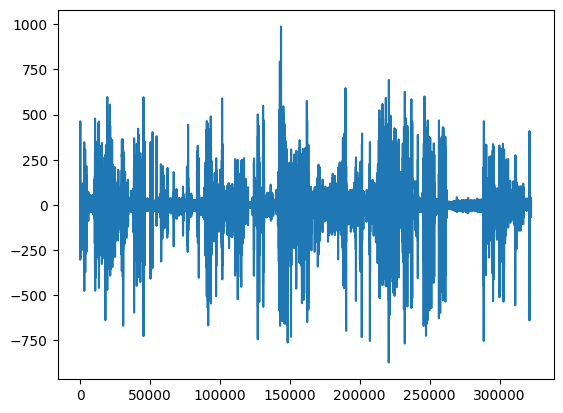

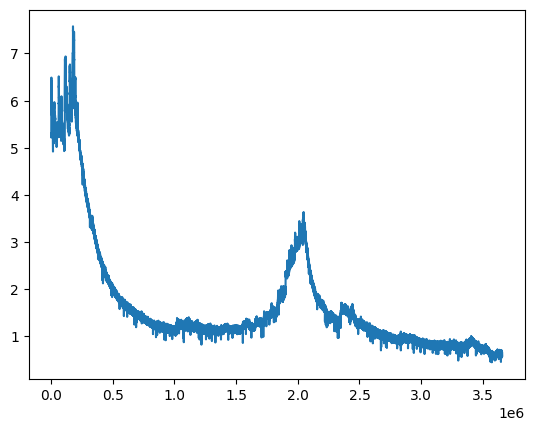

In [86]:
plt.plot(bvp[0])
olt
plt.show()
plt.plot(cEDA[0])


## Random Forest Model

In [30]:
# Length check
# print(len(cEDA_bw[0]),len(cTemp_ma[0]),len(bvp_ma[0])/16)

### Flatten List

In [31]:
for i in ['cTemp_Max', 'cTemp_Min', 'cTemp_Std', 'cTemp_Mean', 'wTemp_Max', 'wTemp_Min', 'wTemp_Std', 'wTemp_Mean',
'ppg_a_S_arr', 'ppg_t_S_arr', 'ppg_t_C_arr', 'ppg_DW_arr', 'ppg_SW_10_arr', 'ppg_SW_25_arr', 'ppg_SW_33_arr', 'ppg_SW_50_arr', 'ppg_SW_66_arr', 
'ppg_SW_75_arr', 'ppg_DW_10_arr', 'ppg_DW_25_arr', 'ppg_DW_33_arr', 'ppg_DW_50_arr', 'ppg_DW_66_arr', 'ppg_DW_75_arr', 'ppg_DW_SW_10_arr', 
'ppg_DW_SW_25_arr', 'ppg_DW_SW_33_arr', 'ppg_DW_SW_50_arr', 'ppg_DW_SW_66_arr', 'ppg_DW_SW_75_arr', 'ppg_PR_mean_arr', 'ppg_zcr_arr', 'ppg_snr_arr', 
'scl_mean_w', 'scl_std_w', 'scl_max_w', 'scl_min_w', 'scl_range_w', 'scl_kurtosis_w', 'scl_skew_w', 'scl_momentum_w', 'scr_mean_w', 'scr_std_w', 
'scr_max_w', 'scr_min_w', 'scr_range_w', 'scr_kurtosis_w', 'scr_skew_w', 'scr_momentum_w', 'scr_activity_w', 'scr_complexity_w', 'scr_mobility_w', 
'scr_rms_w', 'scr_acr_length_w', 'scr_integral_w', 'scr_average_power_w', 'scr_f1sc_w', 'scr_f2sc_w', 'scr_f3sc_w', 'scr_Energy_w', 'scr_Entropy_w', 
'scr_max_freq_w',
'scl_mean_c', 'scl_std_c', 'scl_max_c', 'scl_min_c', 'scl_range_c', 'scl_kurtosis_c', 'scl_skew_c', 'scl_momentum_c', 'scr_mean_c', 'scr_std_c', 
'scr_max_c', 'scr_min_c', 'scr_range_c', 'scr_kurtosis_c', 'scr_skew_c', 'scr_momentum_c', 'scr_activity_c', 'scr_complexity_c', 'scr_mobility_c', 
'scr_rms_c', 'scr_acr_length_c', 'scr_integral_c', 'scr_average_power_c', 'scr_f1sc_c', 'scr_f2sc_c', 'scr_f3sc_c', 'scr_Energy_c', 'scr_Entropy_c', 
'scr_max_freq_c', 
'states_clean_bin', 'states_clean_tri']:
    exec(f'{i}_flat = []')
    for j in range(15):
        exec(f'{i}_flat.append({i}[j])')
    exec(f'{i}_flat = np.asarray({i}_flat)')
    exec(f'{i}_flat = {i}_flat.flatten()')
    #exec(f'print("{i}_flat:",len({i}_flat))')
features = []
for i in ['cTemp_Max', 'cTemp_Min', 'cTemp_Std', 'cTemp_Mean', 'wTemp_Max', 'wTemp_Min', 'wTemp_Std', 'wTemp_Mean',
'ppg_a_S_arr', 'ppg_t_S_arr', 'ppg_t_C_arr', 'ppg_DW_arr', 'ppg_SW_10_arr', 'ppg_SW_25_arr', 'ppg_SW_33_arr', 'ppg_SW_50_arr', 'ppg_SW_66_arr', 
'ppg_SW_75_arr', 'ppg_DW_10_arr', 'ppg_DW_25_arr', 'ppg_DW_33_arr', 'ppg_DW_50_arr', 'ppg_DW_66_arr', 'ppg_DW_75_arr', 'ppg_DW_SW_10_arr', 
'ppg_DW_SW_25_arr', 'ppg_DW_SW_33_arr', 'ppg_DW_SW_50_arr', 'ppg_DW_SW_66_arr', 'ppg_DW_SW_75_arr', 'ppg_PR_mean_arr', 'ppg_zcr_arr', 'ppg_snr_arr', 
'scl_mean_w', 'scl_std_w', 'scl_max_w', 'scl_min_w', 'scl_range_w', 'scl_kurtosis_w', 'scl_skew_w', 'scl_momentum_w', 'scr_mean_w', 'scr_std_w', 
'scr_max_w', 'scr_min_w', 'scr_range_w', 'scr_kurtosis_w', 'scr_skew_w', 'scr_momentum_w', 'scr_activity_w', 'scr_complexity_w', 'scr_mobility_w', 
'scr_rms_w', 'scr_acr_length_w', 'scr_integral_w', 'scr_average_power_w', 'scr_f1sc_w', 'scr_f2sc_w', 'scr_f3sc_w', 'scr_Energy_w', 'scr_Entropy_w', 
'scr_max_freq_w',
'scl_mean_c', 'scl_std_c', 'scl_max_c', 'scl_min_c', 'scl_range_c', 'scl_kurtosis_c', 'scl_skew_c', 'scl_momentum_c', 'scr_mean_c', 'scr_std_c', 
'scr_max_c', 'scr_min_c', 'scr_range_c', 'scr_kurtosis_c', 'scr_skew_c', 'scr_momentum_c', 'scr_activity_c', 'scr_complexity_c', 'scr_mobility_c', 
'scr_rms_c', 'scr_acr_length_c', 'scr_integral_c', 'scr_average_power_c', 'scr_f1sc_c', 'scr_f2sc_c', 'scr_f3sc_c', 'scr_Energy_c', 'scr_Entropy_c', 
'scr_max_freq_c']:
    exec(f'features.append({i}_flat)')
#print(len(features),features)
features = np.transpose(features)

In [34]:
np.shape(features)
print(features)
print(len(features[0]))

for i in range(len(features)):
    for j in range(len(features[0])):
        if features[i][j] == float('inf'):
            features[i][j] = features[i-1][j]
        print(features[i][j])
        
        


[[3.02341309e+01 3.00627136e+01 3.08799241e-02 ... 3.71784471e+01
  1.25580424e+01 2.56410256e-02]
 [3.01352844e+01 2.99742432e+01 3.93700562e-02 ... 4.67608451e+04
  1.52099865e+03 0.00000000e+00]
 [3.01004639e+01 2.98887024e+01 3.72806937e-02 ... 5.31440720e+05
  6.24489274e+03 0.00000000e+00]
 ...
 [3.41306152e+01 3.40300598e+01 2.43467130e-02 ... 1.71130749e+01
  5.26269209e+00 0.00000000e+00]
 [3.42130127e+01 3.40194092e+01 3.59242111e-02 ... 2.40651708e+01
  7.42313101e+00 0.00000000e+00]
 [3.41260376e+01 3.40391846e+01 2.11453326e-02 ... 2.98296039e+01
  9.08722023e+00 0.00000000e+00]]
91
30.234130859375
30.062713623046875
0.030879924073815346
30.098064422607422
35.45
35.41
0.013372722882469061
35.418
70.40211841604409
0.23273026315789475
0.4597039473684211
0.22697368421052633
0.1768092105263158
0.13980263157894737
0.12828947368421054
0.10115131578947369
0.078125
0.06085526315789474
0.16200657894736842
0.14638157894736842
0.13815789473684212
0.11677631578947369
0.096217105263157

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0.22098214285714285
0.20200892857142858
0.17075892857142858
0.13392857142857142
0.11383928571428571
0.940895858900974
0.9897179252769316
0.9804001612299933
1.0871212121212122
1.1216836734693876
1.2348639455782315
92.44444444444444
0.03912363067292645
-0.002078344661383435
-0.03409822481820901
0.0023925801588438786
-0.03016284096183544
-0.038248998448983024
0.008086157487147583
-1.1957792043729338
-0.059037907425518336
5.7244398164933994e-06
-0.03409822481820901
0.0023925801588438786
-0.03016284096183544
-0.038248998448983024
0.008086157487147583
-1.1957792043729338
-0.059037907425518336
5.7244398164933994e-06
5.7244398164933994e-06
3.5894661890501744
0.0043123530023924175
0.03418206219012565
38.00000086228012
1.3298307679101515
0.0011684133755696176
6.311557254425359e-12
6.3595106301098e-12
6.83351781723394e-12
0.0010637612300774737
-0.1817161422382838
0.0
0.10542284754575466
0.005723719613964774
0.11468023537762684
0.09469741053557701
0.01998282484204983
-1.087189403732962
-0.17879135

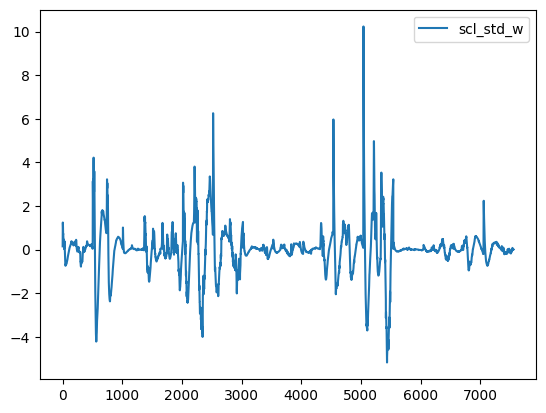

In [67]:
np.shape(features[0])
f = np.transpose(features)
np.shape(f)
# f1 = f[0
# count = 0
# for i in ['cTemp_Max', 'cTemp_Min', 'cTemp_Std', 'cTemp_Mean', 'wTemp_Max', 'wTemp_Min', 'wTemp_Std', 'wTemp_Mean',
# 'ppg_a_S_arr', 'ppg_t_S_arr', 'ppg_t_C_arr', 'ppg_DW_arr', 'ppg_SW_10_arr', 'ppg_SW_25_arr', 'ppg_SW_33_arr', 'ppg_SW_50_arr', 'ppg_SW_66_arr', 
# 'ppg_SW_75_arr', 'ppg_DW_10_arr', 'ppg_DW_25_arr', 'ppg_DW_33_arr', 'ppg_DW_50_arr', 'ppg_DW_66_arr', 'ppg_DW_75_arr', 'ppg_DW_SW_10_arr', 
# 'ppg_DW_SW_25_arr', 'ppg_DW_SW_33_arr', 'ppg_DW_SW_50_arr', 'ppg_DW_SW_66_arr', 'ppg_DW_SW_75_arr', 'ppg_PR_mean_arr', 'ppg_zcr_arr', 'ppg_snr_arr', 
# 'scl_mean_w', 'scl_std_w', 'scl_max_w', 'scl_min_w', 'scl_range_w', 'scl_kurtosis_w', 'scl_skew_w', 'scl_momentum_w', 'scr_mean_w', 'scr_std_w', 
# 'scr_max_w', 'scr_min_w', 'scr_range_w', 'scr_kurtosis_w', 'scr_skew_w', 'scr_momentum_w', 'scr_activity_w', 'scr_complexity_w', 'scr_mobility_w', 
# 'scr_rms_w', 'scr_acr_length_w', 'scr_integral_w', 'scr_average_power_w', 'scr_f1sc_w', 'scr_f2sc_w', 'scr_f3sc_w', 'scr_Energy_w', 'scr_Entropy_w', 
# 'scr_max_freq_w',
# 'scl_mean_c', 'scl_std_c', 'scl_max_c', 'scl_min_c', 'scl_range_c', 'scl_kurtosis_c', 'scl_skew_c', 'scl_momentum_c', 'scr_mean_c', 'scr_std_c', 
# 'scr_max_c', 'scr_min_c', 'scr_range_c', 'scr_kurtosis_c', 'scr_skew_c', 'scr_momentum_c', 'scr_activity_c', 'scr_complexity_c', 'scr_mobility_c', 
# 'scr_rms_c', 'scr_acr_length_c', 'scr_integral_c', 'scr_average_power_c', 'scr_f1sc_c', 'scr_f2sc_c', 'scr_f3sc_c', 'scr_Energy_c', 'scr_Entropy_c', 
# 'scr_max_freq_c']:
#     count=count+1
    
#     print(i,count)
#for i in range(91):
plt.plot(f[35], label = "scl_std_w")
plt.legend()
plt.show()
#     plt.plot(f[i], label =i)
#     plt.legend()
#     plt.show()

### Model

In [35]:
accuracy_sum = 0
for i in range(10):
    xtrain, xtest, ytrain, ytest = train_test_split(features,states_clean_tri_flat,test_size = 0.1)
    #Random Forest Model
    rf = RandomForestClassifier()
    rf.fit(xtrain,ytrain)
    rf_predict = rf.predict(xtest)
    accuracy = rf.score(xtest,ytest)
    accuracy_sum += accuracy
accuracy_sum = accuracy_sum/10
rf_prob = rf.predict_proba(xtest)
print(accuracy_sum, rf_prob)

0.9097883597883596 [[0.2  0.8  0.  ]
 [0.99 0.   0.01]
 [0.97 0.02 0.01]
 ...
 [0.76 0.23 0.01]
 [0.73 0.23 0.04]
 [0.1  0.12 0.78]]


In [ ]:
c1 = 0
c2 = 0
c3 = 0
for i in rf_predict:
    if i == 1:
        c1 += 1
    elif i == 2:
        c2 += 1
    else:
        c3 += 1
print(len(rf_predict),c1+c2+c3,c1/len(rf_predict),c2/len(rf_predict),c3/len(rf_predict))

c1 = 0
c2 = 0
c3 = 0
for i in ytest:
    if i == 1:
        c1 += 1
    elif i == 2:
        c2 += 1
    else:
        c3 += 1
print(len(ytest),c1+c2+c3,c1/len(ytest),c2/len(ytest),c3/len(ytest))
print(rf_predict)

In [ ]:
# # define model evaluation
# #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# model = TPOTClassifier(generations=1, population_size=50,max_time_mins=None, max_eval_time_mins=10, verbosity=2, n_jobs=-1)
# model.fit(xtrain, ytrain)
# model.export('tpot_best_model.py')